In [5]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


In [14]:
from models.mobilenet import mobilenetv2

In [13]:
#from models.resnet import ResNet50
#model=ResNet50(num_classes=3, channels=3)
#model=model.to(device)

# Mobilenet v2 

In [15]:
model=mobilenetv2(num_classes=3)
model=model.to(device)

In [10]:
import pandas as pd
print('traing data')
data = pd.read_csv('./csv_files/data_train.csv')

print(data.head())
# Print the statastis of the given data
print("stastics of the given data:")
print(data['label'].value_counts())
print('#'*100)

print('validation data')

data = pd.read_csv('./csv_files/data_valid.csv')

print(data.head())
# Print the statastis of the given data
print("stastics of the given data:")
print(data['label'].value_counts())
print('#'*100)

print('test data')

data = pd.read_csv('./csv_files/data_test.csv')

print(data.head())
# Print the statastis of the given data
print("stastics of the given data:")
print(data['label'].value_counts())
print('#'*100)


traing data
   Unnamed: 0                                         image_path  \
0        5758  ./processed_data/pocus_videos_to_images/convex...   
1        4244  ./processed_data/pocus_videos_to_images/convex...   
2        9517  ./processed_data/pocus_videos_to_images/convex...   
3         415  ./processed_data/pocus_videos_to_images/linear...   
4       12024  ./processed_data/pocus_videos_to_images/convex...   

                 label  
0                COVID  
1              healthy  
2                COVID  
3              healthy  
4  bacterial pneumonia  
stastics of the given data:
COVID                  3919
healthy                3697
bacterial pneumonia    2733
viral pneumonia         131
Name: label, dtype: int64
####################################################################################################
validation data
   Unnamed: 0                                         image_path  \
0       11813  ./processed_data/pocus_videos_to_images/convex...   
1        9

# Data loader

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from PIL import Image
import numpy as np


# Custom Dataset class for classification
class CustomDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file, usecols=['image_path', 'label'])
        self.transform = transform
        self.class_to_int = {"COVID": 0, "healthy": 1, "bacterial pneumonia": 2,"viral pneumonia": 2}  # Mapping class names to integers



    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        image_path = self.data['image_path'][idx]
        label = self.class_to_int[self.data['label'][idx]]  # Convert class label to integer

        # Load image using PIL
        image = Image.open(image_path)

        # Convert PIL Image to NumPy array
        #image = np.array(image)
        #image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

        if self.transform:
            image = self.transform(image)
        #print(image.shape,label)




        image=image[:3,:,:]



        #print(np.unique(image))
        return image, label

# Transform

In [7]:
import torchvision.transforms as transforms

# Define transformations for data augmentation or normalization
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize image to required size
    transforms.ToTensor()
])

In [8]:
!pip install tqdm

In [26]:

# Assuming you have a CSV file named 'data.csv' with image paths and class labels
train_csv_file = './drive/MyDrive/Aster/Aster_AI_Course/TA_Projects_Session_2_LUNG_USG_Classification/csv_files/data_train.csv'

# Create CustomDataset instance
dataset = CustomDataset('./csv_files/data_train.csv', transform=transform)
train_loader = DataLoader(dataset, batch_size=8, shuffle=False)

val_dataset = CustomDataset('./csv_files/data_valid.csv', transform=transform)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False)

test_dataset = CustomDataset('./csv_files/data_test.csv', transform=transform)
test_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False)

print(len(test_dataloader))
print(len(train_loader))
print(len(val_dataloader))
print(len(test_dataloader))






164
1310
164
164


In [10]:
num_classes = 3  # Assuming 3 classes: "covid", "normal", "pneumonia"


learning_rate=0.0001
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [11]:
# Train your model
from tqdm import tqdm

# Define your training function
model.train()
train_losses = []  # List to store training losses
val_losses = []  # List to store validaion losses

num_epochs=50



for epoch in range(num_epochs):
    running_loss = 0.0
    validation_loss=0.0
    
    y_true_train = []
    y_pred_train = []


    # Create tqdm progress bar
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f'Epoch {epoch + 1}/{num_epochs}')

    for batch_idx, (images, labels) in progress_bar:
        images = images.to(device)
        labels = labels.to(device)
        #images=images/255
        #print(torch.unique(images))
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        y_pred_train.extend(outputs.detach().argmax(dim=-1).tolist())
        y_true_train.extend(labels.detach().tolist())

        
        # Update progress bar description with current loss
        progress_bar.set_postfix({'Loss': running_loss / (batch_idx + 1)})

        
    total_correct = len([True for x, y in zip(y_pred_train, y_true_train) if x==y])
    total = len(y_pred_train)
    accuracy = total_correct * 100 / total
    print("-------------------------------------------------")
    print("Epoch: {} Train mean loss: {:.8f}".format(epoch, running_loss))
    print("Train Accuracy%: ", accuracy, "==", total_correct, "/", total)
    print("-------------------------------------------------")
        
    save_path='./saved_models/mymodel_'+str(epoch)+'.pth'
    torch.save(model.state_dict(), save_path)
    print(f'Model saved at: {save_path}')

    # storing the train losses
    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}')

    progress_bar = tqdm(enumerate(val_dataloader), total=len(val_dataloader), desc=f'Epoch {epoch + 1}/{num_epochs}')

    y_true_val = []
    y_pred_val = []

    
    model.eval()
    for batch_idx, (images, labels) in progress_bar:
        images = images.to(device)
        labels = labels.to(device)
        #images=images/255
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)

        validation_loss += loss.item()

        y_pred_val.extend(outputs.detach().argmax(dim=-1).tolist())
        y_true_val.extend(labels.detach().tolist())

        
        
        # Update progress bar description with current loss
        progress_bar.set_postfix({'Validation Loss': validation_loss / (batch_idx + 1)})

    # storing the validation losses

    epoch_loss = validation_loss / len(val_dataloader)
    val_losses.append(epoch_loss)

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}')
    
    total_correct = len([True for x, y in zip(y_pred_val, y_true_val) if x==y])
    total = len(y_true_val)
    accuracy = total_correct * 100 / total

    print("-------------------------------------------------")
    print("Epoch: {} Val mean loss: {:.8f}".format(epoch, validation_loss))
    print("       valiation Accuracy%: ", accuracy, "==", total_correct, "/", total)
    print("-------------------------------------------------")


Epoch 1/50: 100%|██████████| 1310/1310 [01:28<00:00, 14.85it/s, Loss=0.391]


-------------------------------------------------
Epoch: 0 Train mean loss: 512.76920052
Train Accuracy%:  84.06488549618321 == 8810 / 10480
-------------------------------------------------
Model saved at: ./saved_models/mymodel_0.pth
Epoch [1/50], Loss: 0.3914


Epoch 1/50: 100%|██████████| 164/164 [00:08<00:00, 19.85it/s, Validation Loss=0.0717]


Epoch [1/50], Loss: 0.0717
-------------------------------------------------
Epoch: 0 Val mean loss: 11.75519185
       valiation Accuracy%:  98.16793893129771 == 1286 / 1310
-------------------------------------------------


Epoch 2/50: 100%|██████████| 1310/1310 [01:27<00:00, 15.01it/s, Loss=0.103]


-------------------------------------------------
Epoch: 1 Train mean loss: 134.34982932
Train Accuracy%:  96.7175572519084 == 10136 / 10480
-------------------------------------------------
Model saved at: ./saved_models/mymodel_1.pth
Epoch [2/50], Loss: 0.1026


Epoch 2/50: 100%|██████████| 164/164 [00:08<00:00, 20.29it/s, Validation Loss=0.0316]


Epoch [2/50], Loss: 0.0316
-------------------------------------------------
Epoch: 1 Val mean loss: 5.18992622
       valiation Accuracy%:  98.93129770992367 == 1296 / 1310
-------------------------------------------------


Epoch 3/50: 100%|██████████| 1310/1310 [01:27<00:00, 15.06it/s, Loss=0.0321]


-------------------------------------------------
Epoch: 2 Train mean loss: 42.05788799
Train Accuracy%:  98.91221374045801 == 10366 / 10480
-------------------------------------------------
Model saved at: ./saved_models/mymodel_2.pth
Epoch [3/50], Loss: 0.0321


Epoch 3/50: 100%|██████████| 164/164 [00:07<00:00, 20.59it/s, Validation Loss=0.0452]


Epoch [3/50], Loss: 0.0452
-------------------------------------------------
Epoch: 2 Val mean loss: 7.40505459
       valiation Accuracy%:  98.70229007633588 == 1293 / 1310
-------------------------------------------------


Epoch 4/50: 100%|██████████| 1310/1310 [01:27<00:00, 15.05it/s, Loss=0.0254]


-------------------------------------------------
Epoch: 3 Train mean loss: 33.23447883
Train Accuracy%:  99.24618320610686 == 10401 / 10480
-------------------------------------------------
Model saved at: ./saved_models/mymodel_3.pth
Epoch [4/50], Loss: 0.0254


Epoch 4/50: 100%|██████████| 164/164 [00:08<00:00, 19.97it/s, Validation Loss=0.0152]


Epoch [4/50], Loss: 0.0152
-------------------------------------------------
Epoch: 3 Val mean loss: 2.49756637
       valiation Accuracy%:  99.46564885496183 == 1303 / 1310
-------------------------------------------------


Epoch 5/50: 100%|██████████| 1310/1310 [01:26<00:00, 15.06it/s, Loss=0.0224]


-------------------------------------------------
Epoch: 4 Train mean loss: 29.28618966
Train Accuracy%:  99.35114503816794 == 10412 / 10480
-------------------------------------------------
Model saved at: ./saved_models/mymodel_4.pth
Epoch [5/50], Loss: 0.0224


Epoch 5/50: 100%|██████████| 164/164 [00:08<00:00, 19.92it/s, Validation Loss=0.0199]


Epoch [5/50], Loss: 0.0199
-------------------------------------------------
Epoch: 4 Val mean loss: 3.26956622
       valiation Accuracy%:  99.69465648854961 == 1306 / 1310
-------------------------------------------------


Epoch 6/50: 100%|██████████| 1310/1310 [01:27<00:00, 15.03it/s, Loss=0.0171]


-------------------------------------------------
Epoch: 5 Train mean loss: 22.36459557
Train Accuracy%:  99.47519083969466 == 10425 / 10480
-------------------------------------------------
Model saved at: ./saved_models/mymodel_5.pth
Epoch [6/50], Loss: 0.0171


Epoch 6/50: 100%|██████████| 164/164 [00:08<00:00, 20.08it/s, Validation Loss=0.0225]


Epoch [6/50], Loss: 0.0225
-------------------------------------------------
Epoch: 5 Val mean loss: 3.69497733
       valiation Accuracy%:  99.46564885496183 == 1303 / 1310
-------------------------------------------------


Epoch 7/50: 100%|██████████| 1310/1310 [01:26<00:00, 15.09it/s, Loss=0.011] 


-------------------------------------------------
Epoch: 6 Train mean loss: 14.35764503
Train Accuracy%:  99.65648854961832 == 10444 / 10480
-------------------------------------------------
Model saved at: ./saved_models/mymodel_6.pth
Epoch [7/50], Loss: 0.0110


Epoch 7/50: 100%|██████████| 164/164 [00:08<00:00, 19.93it/s, Validation Loss=0.0147] 


Epoch [7/50], Loss: 0.0147
-------------------------------------------------
Epoch: 6 Val mean loss: 2.41684798
       valiation Accuracy%:  99.69465648854961 == 1306 / 1310
-------------------------------------------------


Epoch 8/50: 100%|██████████| 1310/1310 [01:26<00:00, 15.10it/s, Loss=0.0195] 


-------------------------------------------------
Epoch: 7 Train mean loss: 25.53531349
Train Accuracy%:  99.41793893129771 == 10419 / 10480
-------------------------------------------------
Model saved at: ./saved_models/mymodel_7.pth
Epoch [8/50], Loss: 0.0195


Epoch 8/50: 100%|██████████| 164/164 [00:08<00:00, 20.35it/s, Validation Loss=0.00864]


Epoch [8/50], Loss: 0.0086
-------------------------------------------------
Epoch: 7 Val mean loss: 1.41705911
       valiation Accuracy%:  99.69465648854961 == 1306 / 1310
-------------------------------------------------


Epoch 9/50: 100%|██████████| 1310/1310 [01:26<00:00, 15.13it/s, Loss=0.0101] 


-------------------------------------------------
Epoch: 8 Train mean loss: 13.24678290
Train Accuracy%:  99.65648854961832 == 10444 / 10480
-------------------------------------------------
Model saved at: ./saved_models/mymodel_8.pth
Epoch [9/50], Loss: 0.0101


Epoch 9/50: 100%|██████████| 164/164 [00:08<00:00, 20.39it/s, Validation Loss=0.0121] 


Epoch [9/50], Loss: 0.0121
-------------------------------------------------
Epoch: 8 Val mean loss: 1.97641068
       valiation Accuracy%:  99.69465648854961 == 1306 / 1310
-------------------------------------------------


Epoch 10/50: 100%|██████████| 1310/1310 [01:27<00:00, 14.97it/s, Loss=0.00944]


-------------------------------------------------
Epoch: 9 Train mean loss: 12.36420130
Train Accuracy%:  99.66603053435115 == 10445 / 10480
-------------------------------------------------
Model saved at: ./saved_models/mymodel_9.pth
Epoch [10/50], Loss: 0.0094


Epoch 10/50: 100%|██████████| 164/164 [00:08<00:00, 20.38it/s, Validation Loss=0.0933]


Epoch [10/50], Loss: 0.0933
-------------------------------------------------
Epoch: 9 Val mean loss: 15.30647402
       valiation Accuracy%:  96.87022900763358 == 1269 / 1310
-------------------------------------------------


Epoch 11/50: 100%|██████████| 1310/1310 [01:26<00:00, 15.08it/s, Loss=0.0134] 


-------------------------------------------------
Epoch: 10 Train mean loss: 17.57857400
Train Accuracy%:  99.59923664122137 == 10438 / 10480
-------------------------------------------------
Model saved at: ./saved_models/mymodel_10.pth
Epoch [11/50], Loss: 0.0134


Epoch 11/50: 100%|██████████| 164/164 [00:08<00:00, 19.70it/s, Validation Loss=0.0119]


Epoch [11/50], Loss: 0.0119
-------------------------------------------------
Epoch: 10 Val mean loss: 1.94771242
       valiation Accuracy%:  99.77099236641222 == 1307 / 1310
-------------------------------------------------


Epoch 12/50: 100%|██████████| 1310/1310 [01:27<00:00, 15.03it/s, Loss=0.00541]


-------------------------------------------------
Epoch: 11 Train mean loss: 7.08142022
Train Accuracy%:  99.8473282442748 == 10464 / 10480
-------------------------------------------------
Model saved at: ./saved_models/mymodel_11.pth
Epoch [12/50], Loss: 0.0054


Epoch 12/50: 100%|██████████| 164/164 [00:08<00:00, 20.29it/s, Validation Loss=0.0117] 


Epoch [12/50], Loss: 0.0117
-------------------------------------------------
Epoch: 11 Val mean loss: 1.91282011
       valiation Accuracy%:  99.77099236641222 == 1307 / 1310
-------------------------------------------------


Epoch 13/50: 100%|██████████| 1310/1310 [01:27<00:00, 15.00it/s, Loss=0.00509]


-------------------------------------------------
Epoch: 12 Train mean loss: 6.67247287
Train Accuracy%:  99.82824427480917 == 10462 / 10480
-------------------------------------------------
Model saved at: ./saved_models/mymodel_12.pth
Epoch [13/50], Loss: 0.0051


Epoch 13/50: 100%|██████████| 164/164 [00:08<00:00, 20.13it/s, Validation Loss=0.0136]


Epoch [13/50], Loss: 0.0136
-------------------------------------------------
Epoch: 12 Val mean loss: 2.23697045
       valiation Accuracy%:  99.77099236641222 == 1307 / 1310
-------------------------------------------------


Epoch 14/50: 100%|██████████| 1310/1310 [01:26<00:00, 15.09it/s, Loss=2.73e-5]


-------------------------------------------------
Epoch: 13 Train mean loss: 0.03574299
Train Accuracy%:  100.0 == 10480 / 10480
-------------------------------------------------
Model saved at: ./saved_models/mymodel_13.pth
Epoch [14/50], Loss: 0.0000


Epoch 14/50: 100%|██████████| 164/164 [00:08<00:00, 20.20it/s, Validation Loss=0.0143]


Epoch [14/50], Loss: 0.0143
-------------------------------------------------
Epoch: 13 Val mean loss: 2.34780596
       valiation Accuracy%:  99.77099236641222 == 1307 / 1310
-------------------------------------------------


Epoch 15/50: 100%|██████████| 1310/1310 [01:27<00:00, 15.04it/s, Loss=1.12e-5]


-------------------------------------------------
Epoch: 14 Train mean loss: 0.01467795
Train Accuracy%:  100.0 == 10480 / 10480
-------------------------------------------------
Model saved at: ./saved_models/mymodel_14.pth
Epoch [15/50], Loss: 0.0000


Epoch 15/50: 100%|██████████| 164/164 [00:08<00:00, 20.31it/s, Validation Loss=0.0147]


Epoch [15/50], Loss: 0.0147
-------------------------------------------------
Epoch: 14 Val mean loss: 2.41897120
       valiation Accuracy%:  99.77099236641222 == 1307 / 1310
-------------------------------------------------


Epoch 16/50: 100%|██████████| 1310/1310 [01:27<00:00, 15.03it/s, Loss=5.39e-6]


-------------------------------------------------
Epoch: 15 Train mean loss: 0.00706250
Train Accuracy%:  100.0 == 10480 / 10480
-------------------------------------------------
Model saved at: ./saved_models/mymodel_15.pth
Epoch [16/50], Loss: 0.0000


Epoch 16/50: 100%|██████████| 164/164 [00:08<00:00, 20.18it/s, Validation Loss=0.0153]


Epoch [16/50], Loss: 0.0153
-------------------------------------------------
Epoch: 15 Val mean loss: 2.50543768
       valiation Accuracy%:  99.77099236641222 == 1307 / 1310
-------------------------------------------------


Epoch 17/50: 100%|██████████| 1310/1310 [01:27<00:00, 15.01it/s, Loss=2.55e-6]


-------------------------------------------------
Epoch: 16 Train mean loss: 0.00333904
Train Accuracy%:  100.0 == 10480 / 10480
-------------------------------------------------
Model saved at: ./saved_models/mymodel_16.pth
Epoch [17/50], Loss: 0.0000


Epoch 17/50: 100%|██████████| 164/164 [00:08<00:00, 20.04it/s, Validation Loss=0.0158]


Epoch [17/50], Loss: 0.0158
-------------------------------------------------
Epoch: 16 Val mean loss: 2.58360489
       valiation Accuracy%:  99.77099236641222 == 1307 / 1310
-------------------------------------------------


Epoch 18/50: 100%|██████████| 1310/1310 [01:27<00:00, 15.03it/s, Loss=1.25e-6]


-------------------------------------------------
Epoch: 17 Train mean loss: 0.00163190
Train Accuracy%:  100.0 == 10480 / 10480
-------------------------------------------------
Model saved at: ./saved_models/mymodel_17.pth
Epoch [18/50], Loss: 0.0000


Epoch 18/50: 100%|██████████| 164/164 [00:08<00:00, 20.39it/s, Validation Loss=0.0162]


Epoch [18/50], Loss: 0.0162
-------------------------------------------------
Epoch: 17 Val mean loss: 2.65100105
       valiation Accuracy%:  99.77099236641222 == 1307 / 1310
-------------------------------------------------


Epoch 19/50: 100%|██████████| 1310/1310 [01:27<00:00, 15.01it/s, Loss=6.17e-7]


-------------------------------------------------
Epoch: 18 Train mean loss: 0.00080771
Train Accuracy%:  100.0 == 10480 / 10480
-------------------------------------------------
Model saved at: ./saved_models/mymodel_18.pth
Epoch [19/50], Loss: 0.0000


Epoch 19/50: 100%|██████████| 164/164 [00:08<00:00, 20.00it/s, Validation Loss=0.0166]


Epoch [19/50], Loss: 0.0166
-------------------------------------------------
Epoch: 18 Val mean loss: 2.71702308
       valiation Accuracy%:  99.77099236641222 == 1307 / 1310
-------------------------------------------------


Epoch 20/50: 100%|██████████| 1310/1310 [01:26<00:00, 15.08it/s, Loss=3.06e-7]


-------------------------------------------------
Epoch: 19 Train mean loss: 0.00040102
Train Accuracy%:  100.0 == 10480 / 10480
-------------------------------------------------
Model saved at: ./saved_models/mymodel_19.pth
Epoch [20/50], Loss: 0.0000


Epoch 20/50: 100%|██████████| 164/164 [00:08<00:00, 20.09it/s, Validation Loss=0.0169]


Epoch [20/50], Loss: 0.0169
-------------------------------------------------
Epoch: 19 Val mean loss: 2.77659962
       valiation Accuracy%:  99.77099236641222 == 1307 / 1310
-------------------------------------------------


Epoch 21/50: 100%|██████████| 1310/1310 [01:26<00:00, 15.11it/s, Loss=1.51e-7]


-------------------------------------------------
Epoch: 20 Train mean loss: 0.00019737
Train Accuracy%:  100.0 == 10480 / 10480
-------------------------------------------------
Model saved at: ./saved_models/mymodel_20.pth
Epoch [21/50], Loss: 0.0000


Epoch 21/50: 100%|██████████| 164/164 [00:08<00:00, 20.13it/s, Validation Loss=0.0173]


Epoch [21/50], Loss: 0.0173
-------------------------------------------------
Epoch: 20 Val mean loss: 2.83794606
       valiation Accuracy%:  99.77099236641222 == 1307 / 1310
-------------------------------------------------


Epoch 22/50: 100%|██████████| 1310/1310 [01:26<00:00, 15.07it/s, Loss=7.36e-8]


-------------------------------------------------
Epoch: 21 Train mean loss: 0.00009641
Train Accuracy%:  100.0 == 10480 / 10480
-------------------------------------------------
Model saved at: ./saved_models/mymodel_21.pth
Epoch [22/50], Loss: 0.0000


Epoch 22/50: 100%|██████████| 164/164 [00:08<00:00, 19.97it/s, Validation Loss=0.0176]


Epoch [22/50], Loss: 0.0176
-------------------------------------------------
Epoch: 21 Val mean loss: 2.89260359
       valiation Accuracy%:  99.77099236641222 == 1307 / 1310
-------------------------------------------------


Epoch 23/50: 100%|██████████| 1310/1310 [01:27<00:00, 15.06it/s, Loss=3.59e-8]


-------------------------------------------------
Epoch: 22 Train mean loss: 0.00004701
Train Accuracy%:  100.0 == 10480 / 10480
-------------------------------------------------
Model saved at: ./saved_models/mymodel_22.pth
Epoch [23/50], Loss: 0.0000


Epoch 23/50: 100%|██████████| 164/164 [00:08<00:00, 20.11it/s, Validation Loss=0.0179]


Epoch [23/50], Loss: 0.0179
-------------------------------------------------
Epoch: 22 Val mean loss: 2.94309393
       valiation Accuracy%:  99.77099236641222 == 1307 / 1310
-------------------------------------------------


Epoch 24/50: 100%|██████████| 1310/1310 [01:27<00:00, 14.99it/s, Loss=1.72e-8]


-------------------------------------------------
Epoch: 23 Train mean loss: 0.00002253
Train Accuracy%:  100.0 == 10480 / 10480
-------------------------------------------------
Model saved at: ./saved_models/mymodel_23.pth
Epoch [24/50], Loss: 0.0000


Epoch 24/50: 100%|██████████| 164/164 [00:08<00:00, 20.13it/s, Validation Loss=0.0182]


Epoch [24/50], Loss: 0.0182
-------------------------------------------------
Epoch: 23 Val mean loss: 2.99150423
       valiation Accuracy%:  99.77099236641222 == 1307 / 1310
-------------------------------------------------


Epoch 25/50: 100%|██████████| 1310/1310 [01:27<00:00, 15.01it/s, Loss=7.99e-9]


-------------------------------------------------
Epoch: 24 Train mean loss: 0.00001046
Train Accuracy%:  100.0 == 10480 / 10480
-------------------------------------------------
Model saved at: ./saved_models/mymodel_24.pth
Epoch [25/50], Loss: 0.0000


Epoch 25/50: 100%|██████████| 164/164 [00:08<00:00, 20.10it/s, Validation Loss=0.0185]


Epoch [25/50], Loss: 0.0185
-------------------------------------------------
Epoch: 24 Val mean loss: 3.02668212
       valiation Accuracy%:  99.77099236641222 == 1307 / 1310
-------------------------------------------------


Epoch 26/50: 100%|██████████| 1310/1310 [01:27<00:00, 14.96it/s, Loss=3.67e-9]


-------------------------------------------------
Epoch: 25 Train mean loss: 0.00000481
Train Accuracy%:  100.0 == 10480 / 10480
-------------------------------------------------
Model saved at: ./saved_models/mymodel_25.pth
Epoch [26/50], Loss: 0.0000


Epoch 26/50: 100%|██████████| 164/164 [00:08<00:00, 20.01it/s, Validation Loss=0.0187]


Epoch [26/50], Loss: 0.0187
-------------------------------------------------
Epoch: 25 Val mean loss: 3.06644221
       valiation Accuracy%:  99.77099236641222 == 1307 / 1310
-------------------------------------------------


Epoch 27/50: 100%|██████████| 1310/1310 [01:26<00:00, 15.08it/s, Loss=1.46e-9]


-------------------------------------------------
Epoch: 26 Train mean loss: 0.00000191
Train Accuracy%:  100.0 == 10480 / 10480
-------------------------------------------------
Model saved at: ./saved_models/mymodel_26.pth
Epoch [27/50], Loss: 0.0000


Epoch 27/50: 100%|██████████| 164/164 [00:08<00:00, 20.39it/s, Validation Loss=0.0191]


Epoch [27/50], Loss: 0.0191
-------------------------------------------------
Epoch: 26 Val mean loss: 3.13311352
       valiation Accuracy%:  99.77099236641222 == 1307 / 1310
-------------------------------------------------


Epoch 28/50: 100%|██████████| 1310/1310 [01:27<00:00, 15.03it/s, Loss=4.55e-10]


-------------------------------------------------
Epoch: 27 Train mean loss: 0.00000060
Train Accuracy%:  100.0 == 10480 / 10480
-------------------------------------------------
Model saved at: ./saved_models/mymodel_27.pth
Epoch [28/50], Loss: 0.0000


Epoch 28/50: 100%|██████████| 164/164 [00:08<00:00, 20.00it/s, Validation Loss=0.0194]


Epoch [28/50], Loss: 0.0194
-------------------------------------------------
Epoch: 27 Val mean loss: 3.18413744
       valiation Accuracy%:  99.77099236641222 == 1307 / 1310
-------------------------------------------------


Epoch 29/50: 100%|██████████| 1310/1310 [01:26<00:00, 15.08it/s, Loss=9.1e-11] 


-------------------------------------------------
Epoch: 28 Train mean loss: 0.00000012
Train Accuracy%:  100.0 == 10480 / 10480
-------------------------------------------------
Model saved at: ./saved_models/mymodel_28.pth
Epoch [29/50], Loss: 0.0000


Epoch 29/50: 100%|██████████| 164/164 [00:08<00:00, 20.29it/s, Validation Loss=0.0199]


Epoch [29/50], Loss: 0.0199
-------------------------------------------------
Epoch: 28 Val mean loss: 3.26794279
       valiation Accuracy%:  99.77099236641222 == 1307 / 1310
-------------------------------------------------


Epoch 30/50: 100%|██████████| 1310/1310 [01:26<00:00, 15.06it/s, Loss=2.27e-11]


-------------------------------------------------
Epoch: 29 Train mean loss: 0.00000003
Train Accuracy%:  100.0 == 10480 / 10480
-------------------------------------------------
Model saved at: ./saved_models/mymodel_29.pth
Epoch [30/50], Loss: 0.0000


Epoch 30/50: 100%|██████████| 164/164 [00:08<00:00, 19.59it/s, Validation Loss=0.0202]


Epoch [30/50], Loss: 0.0202
-------------------------------------------------
Epoch: 29 Val mean loss: 3.31726165
       valiation Accuracy%:  99.77099236641222 == 1307 / 1310
-------------------------------------------------


Epoch 31/50: 100%|██████████| 1310/1310 [01:27<00:00, 14.95it/s, Loss=0]


-------------------------------------------------
Epoch: 30 Train mean loss: 0.00000000
Train Accuracy%:  100.0 == 10480 / 10480
-------------------------------------------------
Model saved at: ./saved_models/mymodel_30.pth
Epoch [31/50], Loss: 0.0000


Epoch 31/50: 100%|██████████| 164/164 [00:08<00:00, 20.19it/s, Validation Loss=0.0206]


Epoch [31/50], Loss: 0.0206
-------------------------------------------------
Epoch: 30 Val mean loss: 3.38463893
       valiation Accuracy%:  99.77099236641222 == 1307 / 1310
-------------------------------------------------


Epoch 32/50:   9%|▉         | 123/1310 [00:08<01:19, 14.97it/s, Loss=0]


KeyboardInterrupt: 

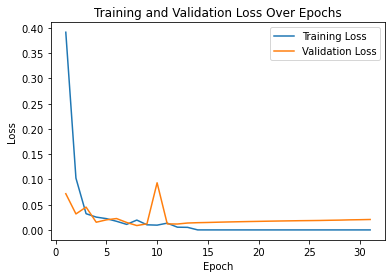

In [12]:
import matplotlib.pyplot as plt

# Plot training and validation losses
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

In [32]:
best_epoch=np.argmin(val_losses)
print('best_epoch:',best_epoch)

best_epoch: 7


# number of parameters

# Total params: 2,227,715

Trainable params: 2,227,715

Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57

Forward/backward pass size (MB): 152.86

Params size (MB): 8.50

Estimated Total Size (MB): 161.93

Computational complexity: 911.67 MMac


Computational complexity: 1823.34 MFlops

Number of parameters: 2.23 M 

In [12]:
from torchsummary import summary

summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
             ReLU6-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
             ReLU6-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             512
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 96, 112, 112]           1,536
      BatchNorm2d-11         [-1, 96, 112, 112]             192
            ReLU6-12         [-1, 96, 112, 112]               0
           Conv2d-13           [-1, 96, 56, 56]             864
      BatchNorm2d-14           [-1, 96,

In [21]:
import re
from ptflops import get_model_complexity_info
from pthflops import count_ops

macs, params = get_model_complexity_info(model, (3, 448, 320), as_strings=True,print_per_layer_stat=False, verbose=False)
# # Extract the numerical value
flops = eval(re.findall(r'([\d.]+)', macs)[0])*2
# Extract the unit
flops_unit = re.findall(r'([A-Za-z]+)', macs)[0][0]

print('Computational complexity: {:<8}'.format(macs))
print('Computational complexity: {} {}Flops'.format(flops, flops_unit))
print('Number of parameters: {:<8}'.format(params))


Computational complexity: 911.67 MMac
Computational complexity: 1823.34 MFlops
Number of parameters: 2.23 M  


# Testing 

In [33]:
ckpt = torch.load('./saved_models/mymodel_7.pth')
model.load_state_dict(ckpt)
model.eval()


MobileNetV2(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
        (3): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
       

In [34]:
from tqdm import tqdm

progress_bar = tqdm(enumerate(test_dataloader), total=len(test_dataloader), desc=f'testing')

y_true_val = []
y_pred_val = []


model.eval()
for batch_idx, (images, labels) in progress_bar:
    images = images.to(device)
    labels = labels.to(device)
    #images=images/255
    optimizer.zero_grad()

    outputs = model(images)

    y_pred_val.extend(outputs.detach().argmax(dim=-1).tolist())
    y_true_val.extend(labels.detach().tolist())



    # Update progress bar description with current loss



total_correct = len([True for x, y in zip(y_pred_val, y_true_val) if x==y])
total = len(y_true_val)
accuracy = total_correct * 100 / total

print("-------------------------------------------------")
print("TEST Accuracy (%): ", accuracy, "==", total_correct, "/", total)
print("-------------------------------------------------")


testing: 100%|██████████| 164/164 [00:07<00:00, 20.75it/s]

-------------------------------------------------
TEST Accuracy (%):  99.69465648854961 == 1306 / 1310
-------------------------------------------------
